# TODO
- napsat 5 nejzajímavějších kryptoměn a zmínit používaný zbytek
- projít všechna data, vypsat základní statistiky (obecný) ke všem a vyselektovat cca 5 nejlepších a u nich se zaměřit na detaily (závislost v čase, na prodaném objemu, na počtu obchodů)
- průměrná doba výskytu trojúhelníku
- napsat k trojúhelníkům denní statistiky výskytu, nejlepších, nejhorších 
- možnost zaměřit se na neefektivitu trhu, zmínit že není regulovaný a proto na něm vznikají arbitráže
- zmínit problémy vytěžitelnosti a jak by to reálně pobíhalo
- průměrný objem nasbíraných dat
- v praktické části popsat strukturu ukládaných dat (csv, json)
- v praktické části se zaměřit na používané algoritmy (jak sbírám order book, do jaké hloubky, jak ho procházím a znovu ukládám) 

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, isdir
from typing import Dict, Tuple, Sequence

In [2]:
def fetch_directories(path: str) -> [str]:    
    directories = []
    try:
        directories = [join(path, f) for f in listdir(path) if isdir(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return directories
    return directories

def fetch_files(path: str) -> [str]:    
    files = []
    try:
        files = [f for f in listdir(path) if isfile(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return files
    return files

In [3]:
class FileHandler:
    def __init__(self, file: str, path: str):
        self.filename = file
        self.total_gain = 0
        self.average_gain = 0
        self.max_gain = 0
        self.best_gains = None
        with open(join(path, file)) as f:
            self.content = json.loads(f.read())
        self.scores = [x["score"] for x in self.content]
    
    @property
    def filename(self) -> str:
        return self.__filename
    
    @filename.setter
    def filename(self, filename: str):
        self.__filename = filename
        
    @property
    def content(self) -> str:
        return self.__content
    
    @content.setter
    def content(self, content: str):
        self.__content = content
        
    @property
    def total_gain(self) -> float:
        return self.__total_gain
    
    @total_gain.setter
    def total_gain(self, total_gain: float):
        self.__total_gain = total_gain
        
    @property
    def max_gain(self) -> float:
        return self.__max_gain
    
    @max_gain.setter
    def max_gain(self, max_gain: float):
        self.__max_gain = max_gain
        
    @property
    def average_gain(self) -> float:
        return self.__average_gain
    
    @average_gain.setter
    def average_gain(self, average_gain: float):
        self.__average_gain = average_gain
        
    @property
    def scores(self) -> str:
        return self.__scores
    
    @scores.setter
    def scores(self, scores: [float]):
        self.__scores = scores
        
    def get_best_indexes_count(self) -> Dict[int, int]:
        indexes = np.array([x['supply_gain_index'] for x in self.content]).ravel()
        tmp = np.array([x['demand_gain_index'] for x in self.content]).ravel()
        indexes = np.array((indexes, tmp)).ravel()
        unique, counts = np.unique(indexes, return_counts = True)
        return dict(zip(unique, counts))
    
    def get_number_of_arbitrages(self) -> int:
        return len(self.scores)
    
    def get_average_score(self) -> float:
        if len(self.scores):
            return sum(self.scores)/len(self.scores)
        return 1
    
    def get_best_score(self) -> float:
        if len(self.scores):
            return max(self.scores)
        return 1
    
    def get_best_gains(self):
        best_gains = np.array([x["supply_gain"] for x in self.content])
        best_gains = np.array((best_gains, [x["supply_gain"] for x in self.content])).ravel()
        best_gains = best_gains[self.best_gains != 0.0]
        self.total_gain = np.sum(best_gains)
        self.average_gain = np.average(best_gains)
        self.max_gain = np.max(best_gains)
        return best_gains

    def get_first_currency(self) -> str:
        return self.content[0]['pairs'][0]['currency'][0:3]

Number of calculated days: 17
Average daily arbitrages: 3872.176470588235
Average score overall: 1.0003028048732794
The best overall score: 1.00311
Overall best gain: 0.000130979 BCH
Total market inefficiency: 0.01506816552294918 BCH
Average daily market inefficiency: 0.004586852818143284 BCH


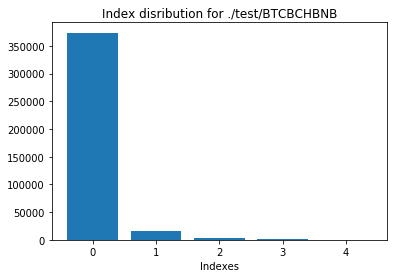

In [9]:
class Triangle:
    def __init__(self, files: [str], path: str):
        self.__files = []
        self.__index_counts = None
        self.__path = path
        self.__best_gains = None
        for f in files:
            self.__files.append(FileHandler(f, path))
            

    @property
    def path(self) -> str:
        return self.__path
            
    def get_best_indexes_count(self) -> Dict[int, int]:
        if self.__index_counts is None:
            index_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for d in np.array([x.get_best_indexes_count() for x in self.__files]):
                for k in d.keys():
                    index_counts[k] += d[k]
            self.__index_counts = index_counts
        return self.__index_counts
    
    def get_daily_number_average_of_arbitrages(self) -> int:
        return sum([x.get_number_of_arbitrages() for x in self.__files])/len(self.__files)
    
    def get_average_score(self) -> float:
        return sum([x.get_average_score() for x in self.__files])/len(self.__files)
    
    def get_best_score(self) -> float:
        return max([x.get_best_score() for x in self.__files])
    
    def get_best_gains(self):
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return self.__best_gains
    
    def get_overall_best_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.max_gain for x in self.__files])
    
    def get_average_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.average([x.total_gain for x in self.__files])
    
    def get_total_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.total_gain for x in self.__files])
    
    def get_first_currency(self) -> str:
        return self.__files[0].get_first_currency()
    
    def get_data_length(self) -> int:
        return len(self.__files)
    

path = "./test/"    

triangles = []
count = 0
for directory in fetch_directories(path):
    triangles.append(Triangle(fetch_files(directory), directory))
    count += 1
    if count == 1:  # only for the first 5
        break

for t in triangles: 
    a = triangles[0].get_best_indexes_count()
    print("Number of calculated days:", t.get_data_length())
    print("Average daily arbitrages:", t.get_daily_number_average_of_arbitrages())
    print("Average score overall:", t.get_average_score())
    print("The best overall score:", t.get_best_score())
    t.get_best_gains()
    print("Overall best gain:", t.get_overall_best_gain(), t.get_first_currency())
    print("Total market inefficiency:", t.get_total_gain(), t.get_first_currency())
    print("Average daily market inefficiency:", t.get_average_gain(), t.get_first_currency())    
    index_distribution = plt.bar(a.keys(), a.values())
    plt.xlabel("Indexes")
    plt.title("Index disribution for " + t.path)
    plt.show()



Praktická část
- Vývoj počtu příležitostí (vytěžitelnosti) v jednotlivých dnech v rámci jednotlivých trojic nebo celkově
- Jaký časový interval (dokdy čekat)
- Nějaké sdružování?
- Selekce nejzajímavějších trojic?
- Přepočet na dolary? (využití aktuálního kurz)


Teoretická část
- Na co se zaměřit v rešerši? (altcoiny, burzy, výběr burz, druhy arbitráží)?


In [46]:
df = {}
with open("./test/BTCBCHBNB/BTCBCHBNB-2020-02-26.json") as f:
    df = json.loads(f.read())
df

[{'score': 1.00016,
  'supply_gain_index': [0, 0, 0],
  'demand_gain_index': [0, 0, 0],
  'supply_gain': 1.14296e-08,
  'demand_gain': 0,
  'calculation_type_linear': 0,
  'pairs': [{'id': 92918138,
    'demand': [[0.035287, 2.11],
     [0.035286, 1.906],
     [0.035279, 2.0],
     [0.035277, 0.963],
     [0.035276, 0.242]],
    'supply': [[0.035314, 0.196],
     [0.035315, 2.0],
     [0.035317, 6.667],
     [0.035336, 0.243],
     [0.035344, 0.243]],
    'timestamp': 1582728843.69997,
    'currency': 'BCHBTC'},
   {'id': 22997311,
    'demand': [[16.892, 0.026],
     [16.872, 0.1],
     [16.866, 0.047],
     [16.853, 0.018],
     [16.851, 0.079]],
    'supply': [[16.926, 0.963],
     [16.927, 0.028],
     [16.962, 0.035],
     [16.974, 3.281],
     [16.975, 20.539]],
    'timestamp': 1582728843.752795,
    'currency': 'BCHBNB'},
   {'id': 584585061,
    'demand': [[0.002091, 1.0],
     [0.00209, 6.16],
     [0.00209, 99.51],
     [0.00209, 89.3],
     [0.00209, 108.07]],
    'supply':

In [3]:
scores = [x["score"] for x in df]
print("Number of arbitrages:", len(scores))
print("Average score:", sum(scores)/len(scores))
print("Maximum score:", max(scores))
print("Minimum score:", min(scores))

Number of arbitrages: 1316
Average score: 1.00043710486322
Maximum score: 1.00307
Minimum score: 1


In [7]:
def get_narrowest(p1: [float], p2: [float], p3: [float]) -> float:
    a = []
    a.append(min(np.prod(p2), p1[1]))
    a.append(min(np.prod(p3), p2[1]))
    a.append(min(np.prod(p1), p3[1]))
    a[1] = a[1] * p1[0]
    a[2] = a[2] * p2[0] * p1[0]
    return min(a)


# def get_max_gain(df):
#     pairs = df['pairs']
#     max_gain = 0
#     for p1 in pairs[0]['supply']:
#         for p2 in pairs[1]['demand']:
#             for p3 in pairs[2]['demand']:
#                 score = p1[0]/p2[0]/p3[0]
#                 if score > 1:
#                     gain = get_narrowest(p1, p2, p3) * (score-1)
#                     if max_gain < gain:
#                         max_gain = gain
#     return max_gain

# gains = []
# for d in df:
#     gains.append(get_max_gain(d))

# currency = df[0]['pairs'][0]['currency'][0:3]
# print("Total daily market inefficiency:", sum(gains), currency)
# print("Max theoretical daily gain:", max(gains), currency)

Total daily market inefficiency: 0.04784531213980099 BCH
Max theoretical daily gain: 0.00048003769667434744 BCH
